# Кросс-валидация - бинарная классификация

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, AutoTrees, base_pipe

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  1.2.1
xgboost:  1.5.2
matplotlib:  3.7.0
autobinary:  1.0.9


## 1.1 Загрузка выборки

In [5]:
sample = pd.read_csv('../data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex  \
0                            Braund, Mr. Owen Harris    male   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   

                   Age  SibSp  Parch     Ticket                 Fare Cabin  \
0                22.00      1      0  A/5 21171                 7.25   NaN   
1                38.00      1      0   PC 17599                71.28   C85   

  Embarked  
0        S  
1        C

In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    sample[num_columns+cat_columns],
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
y_train[target].value_counts()

Survived
0           384
1           239
dtype: int64

In [9]:
y_val[target].value_counts()

Survived
0           165
1           103
dtype: int64

## 1.2 Определяем конвейер обработки, стратегию CV

In [10]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [11]:
# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

## 2. DecisionTreeClassifier

In [12]:
params = {
    'criterion':'gini',
    'max_depth':5,
    'random_state':42}

fit_params = {}

dt = DecisionTreeClassifier(**params)

In [13]:
dt_model = AutoTrees(
    main_estimator=dt, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'decisiontree')

In [14]:
dt_model.model_fit_cv(strat=strat)

1it [00:00,  8.25it/s]

==================== Обучение 1 фолда! ====================
gini на обучающей выборке: 86.780
gini на проверочной выборке: 51.407

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


4it [00:00,  7.72it/s]

gini на обучающей выборке: 85.185
gini на проверочной выборке: 56.683

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
gini на обучающей выборке: 83.507
gini на проверочной выборке: 57.522

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
gini на обучающей выборке: 80.817
gini на проверочной выборке: 77.342

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


5it [00:00,  7.65it/s]

gini на обучающей выборке: 81.900
gini на проверочной выборке: 69.353

********************** 5 фолд обучен! ******************************




In [15]:
dt_model.get_mean_cv_scores()

62.46126983319033

In [16]:
dt_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.93                 0.93                 0.92   
1   roc_valid                 0.76                 0.78                 0.79   
2  gini_train                86.78                85.19                83.51   
3  gini_valid                51.41                56.68                57.52   

                fold_4               fold_5  
0                 0.90                 0.91  
1                 0.89                 0.85  
2                80.82                81.90  
3                77.34                69.35

In [17]:
fi = dt_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex                 0.53                 0.51                 0.55   
1      Fare                 0.16                 0.15                 0.13   
2       Age                 0.12                 0.12                 0.13   
3    Pclass                 0.10                 0.11                 0.12   
4     SibSp                 0.07                 0.05                 0.02   
5     Parch                 0.02                 0.04                 0.03   
6  Embarked                 0.01                 0.02                 0.01   

          importance 3         importance 4      mean_importance  
0                 0.52                 0.54                 0.53  
1                 0.14                 0.17                 0.15  
2                 0.12                 0.11                 0.12  
3                 0.13                 0.10                 0.11  
4                 0.05                 0.04                 0.04  
5                 0.04                 0.05                 0.04  
6                 0.01                 0.00                 0.01

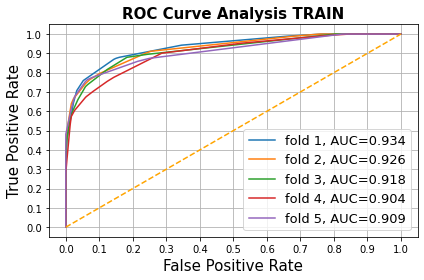

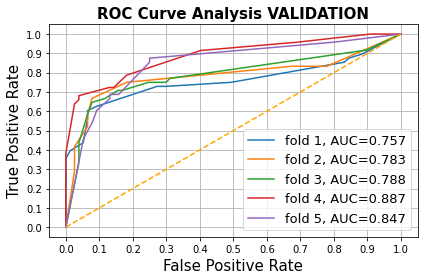

In [18]:
dt_model.get_rocauc_plots()

## 3. RandomForestClassifier

In [19]:
params = {
    'criterion':'gini',
    'max_depth':5,
    'random_state':42,
    'n_estimators':50}

fit_params = {}

rf = RandomForestClassifier(**params)

In [20]:
rf_model = AutoTrees(
    main_estimator=rf, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'randomforest')

In [21]:
rf_model.model_fit_cv(strat=strat)

1it [00:00,  5.34it/s]

==================== Обучение 1 фолда! ====================
gini на обучающей выборке: 86.242
gini на проверочной выборке: 61.851

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  5.70it/s]

gini на обучающей выборке: 84.622
gini на проверочной выборке: 72.971

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
gini на обучающей выборке: 85.622
gini на проверочной выборке: 68.642

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  5.64it/s]

gini на обучающей выборке: 83.671
gini на проверочной выборке: 77.950

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
gini на обучающей выборке: 84.244
gini на проверочной выборке: 79.194

********************** 5 фолд обучен! ******************************




In [22]:
rf_model.get_mean_cv_scores()

72.12139845503506

In [23]:
rf_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.93                 0.92                 0.93   
1   roc_valid                 0.81                 0.86                 0.84   
2  gini_train                86.24                84.62                85.62   
3  gini_valid                61.85                72.97                68.64   

                fold_4               fold_5  
0                 0.92                 0.92  
1                 0.89                 0.90  
2                83.67                84.24  
3                77.95                79.19

In [24]:
fi = rf_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex                 0.39                 0.34                 0.36   
1      Fare                 0.21                 0.24                 0.26   
2    Pclass                 0.13                 0.15                 0.11   
3       Age                 0.10                 0.11                 0.10   
4     Parch                 0.06                 0.07                 0.07   
5     SibSp                 0.07                 0.06                 0.06   
6  Embarked                 0.04                 0.04                 0.04   

          importance 3         importance 4      mean_importance  
0                 0.34                 0.39                 0.36  
1                 0.22                 0.22                 0.23  
2                 0.15                 0.10                 0.13  
3                 0.10                 0.13                 0.11  
4                 0.06                 0.07                 0.07  
5                 0.07                 0.06                 0.06  
6                 0.05                 0.04                 0.04

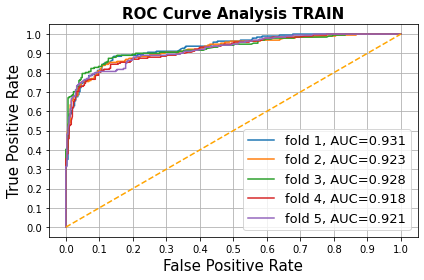

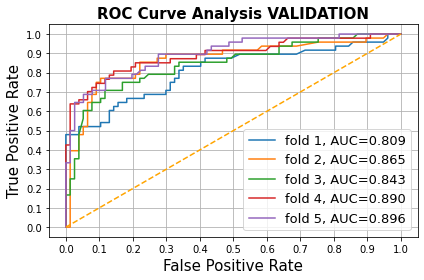

In [25]:
rf_model.get_rocauc_plots()

## 4. XGBClassifier + delta_gini

In [26]:
params = {
    'eta':0.01,
    'n_estimators':800,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary:logistic',
    'use_label_encoder':False,
    'n_jobs':-1,
    'random_state':42}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'aucpr', 'auc'],
    'verbose':25}

# создаем экземпляр класса XGBClassifier
xgb = XGBClassifier(**params)

In [27]:
xgb_model = AutoTrees(
    main_estimator=xgb, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='delta_gini',
    model_type = 'xgboost')

In [28]:
xgb_model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[0]	validation_0-logloss:0.68862	validation_0-aucpr:0.82464	validation_0-auc:0.85384	validation_1-logloss:0.68957	validation_1-aucpr:0.75912	validation_1-auc:0.78044
[25]	validation_0-logloss:0.60169	validation_0-aucpr:0.91323	validation_0-auc:0.92654	validation_1-logloss:0.62922	validation_1-aucpr:0.80202	validation_1-auc:0.81412
[50]	validation_0-logloss:0.53744	validation_0-aucpr:0.91984	validation_0-auc:0.93535	validation_1-logloss:0.58798	validation_1-aucpr:0.80113	validation_1-auc:0.81209
[75]	validation_0-logloss:0.48467	validation_0-aucpr:0.92145	validation_0-auc:0.93763	validation_1-logloss:0.55514	validation_1-aucpr:0.80150	validation_1-auc:0.81277
[100]	validation_0-logloss:0.44717	validation_0-aucpr:0.92591	validation_0-auc:0.94113	validation_1-logloss:0.53437	validation_1-aucpr:0.80447	validation_1-auc:0.81521
[114]	validation_0-logloss:0.42949	validation_0-aucpr:0.92591	validation_0-auc:0.94128	validation_1-loglo

1it [00:00,  3.93it/s]

BEST ITERATION:  14
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.329

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[0]	validation_0-logloss:0.68883	validation_0-aucpr:0.81298	validation_0-auc:0.84262	validation_1-logloss:0.68888	validation_1-aucpr:0.81711	validation_1-auc:0.83117
[25]	validation_0-logloss:0.60603	validation_0-aucpr:0.90711	validation_0-auc:0.92214	validation_1-logloss:0.62407	validation_1-aucpr:0.79342	validation_1-auc:0.85119
[50]	validation_0-logloss:0.54378	validation_0-aucpr:0.91256	validation_0-auc:0.92658	validation_1-logloss:0.57815	validation_1-aucpr:0.79338	validation_1-auc:0.85322
[75]	validation_0-logloss:0.49273	validation_0-aucpr:0.91672	validation_0-auc:0.92951	validation_1-logloss:0.53957	validation_1-aucpr:0.78358	validation_1-auc:0.85620
[100]	validation_0-logloss:0.45601	validation_0-aucpr:0.92129	validation_0-auc:0.93322	validation_1-log

2it [00:00,  3.60it/s]

BEST ITERATION:  38
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.182

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[0]	validation_0-logloss:0.68867	validation_0-aucpr:0.82966	validation_0-auc:0.86378	validation_1-logloss:0.68902	validation_1-aucpr:0.77511	validation_1-auc:0.81291
[25]	validation_0-logloss:0.60449	validation_0-aucpr:0.91546	validation_0-auc:0.92401	validation_1-logloss:0.62353	validation_1-aucpr:0.79974	validation_1-auc:0.85146
[50]	validation_0-logloss:0.54143	validation_0-aucpr:0.92133	validation_0-auc:0.93061	validation_1-logloss:0.57602	validation_1-aucpr:0.81068	validation_1-auc:0.85281
[75]	validation_0-logloss:0.48843	validation_0-aucpr:0.92377	validation_0-auc:0.93415	validation_1-logloss:0.53795	validation_1-aucpr:0.80984	validation_1-auc:0.85484
[100]	validation_0-logloss:0.45128	validation_0-aucpr:0.92823	validation_0-auc:0.93764	validation_1-log

3it [00:00,  3.03it/s]

delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.224

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[0]	validation_0-logloss:0.68881	validation_0-aucpr:0.81380	validation_0-auc:0.84792	validation_1-logloss:0.68858	validation_1-aucpr:0.83745	validation_1-auc:0.85396
[25]	validation_0-logloss:0.60917	validation_0-aucpr:0.90532	validation_0-auc:0.92031	validation_1-logloss:0.61376	validation_1-aucpr:0.89228	validation_1-auc:0.91075
[50]	validation_0-logloss:0.55064	validation_0-aucpr:0.90900	validation_0-auc:0.92331	validation_1-logloss:0.55876	validation_1-aucpr:0.89897	validation_1-auc:0.91158
[75]	validation_0-logloss:0.50381	validation_0-aucpr:0.91488	validation_0-auc:0.92750	validation_1-logloss:0.51543	validation_1-aucpr:0.90070	validation_1-auc:0.91268
[100]	validation_0-logloss:0.46836	validation_0-aucpr:0.91788	validation_0-auc:0.92970	validation_1-logloss:0.48445	validat

4it [00:01,  3.00it/s]

BEST ITERATION:  13
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.003

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[0]	validation_0-logloss:0.68893	validation_0-aucpr:0.81213	validation_0-auc:0.83895	validation_1-logloss:0.68880	validation_1-aucpr:0.83152	validation_1-auc:0.88322
[25]	validation_0-logloss:0.60709	validation_0-aucpr:0.91020	validation_0-auc:0.91658	validation_1-logloss:0.61650	validation_1-aucpr:0.86501	validation_1-auc:0.88871
[50]	validation_0-logloss:0.54709	validation_0-aucpr:0.91240	validation_0-auc:0.92005	validation_1-logloss:0.56586	validation_1-aucpr:0.86106	validation_1-auc:0.89200
[75]	validation_0-logloss:0.50051	validation_0-aucpr:0.91626	validation_0-auc:0.92437	validation_1-logloss:0.52572	validation_1-aucpr:0.86477	validation_1-auc:0.89337
[100]	validation_0-logloss:0.46468	validation_0-aucpr:0.91797	validation_0-auc:0.92691	validation_1-log

5it [00:01,  3.20it/s]

BEST ITERATION:  7
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.017

********************** 5 фолд обучен! ******************************




In [29]:
xgb_model.get_mean_cv_scores()

0.15098091411966932

In [30]:
xgb_model._best_iters

[14, 38, 143, 13, 7]

In [31]:
xgb_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.93                 0.92                 0.94   
1   roc_valid                 0.82                 0.86                 0.86   
2  gini_train                85.41                84.94                88.43   
3  gini_valid                64.29                71.83                72.27   

                fold_4               fold_5  
0                 0.92                 0.91  
1                 0.92                 0.90  
2                83.02                81.55  
3                83.26                80.15

In [32]:
fi = xgb_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex                70.46                56.71                42.15   
1    Pclass                10.03                 7.48                 4.64   
2      Fare                 2.61                 2.93                 2.23   
3     Parch                 2.16                 2.21                 1.79   
4     SibSp                 2.25                 1.85                 1.48   
5  Embarked                 2.34                 1.47                 1.31   
6       Age                 2.00                 1.70                 1.48   

          importance 3         importance 4      mean_importance  
0                62.32                72.22                60.77  
1                11.04                 6.86                 8.01  
2                 2.67                 3.10                 2.71  
3                 2.40                 2.80                 2.27  
4                 2.58                 2.27                 2.09  
5                 2.54                 1.64                 1.86  
6                 1.78                 1.75                 1.74

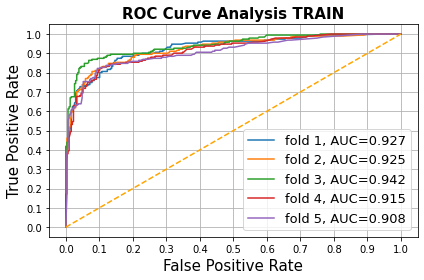

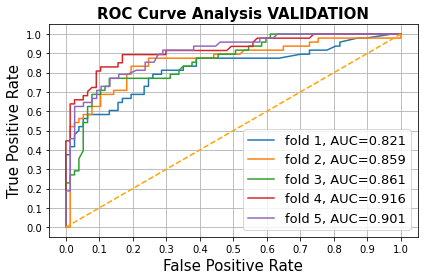

In [33]:
xgb_model.get_rocauc_plots()

In [34]:
xgb_model.get_curve_plots()

## 5. CatBoostClassifier

In [35]:
params = {
    'learning_rate':0.01,
    'iterations':1000,
    'subsample':0.9,
    'colsample_bylevel':0.9,
    'depth':6,
    'loss_function':'Logloss',
    'thread_count':-1,
    'random_state':42,
    'eval_metric':'AUC',
    #'custom_metric':'Logloss',
    'logging_level':'Verbose'}

fit_params = {
    'use_best_model':True,
    'early_stopping_rounds':200, 
    'verbose':50,
    'plot':False}

# создаем экземпляр класса XGBClassifier
catb = CatBoostClassifier(**params)

In [36]:
catb_model = AutoTrees(
    main_estimator=catb, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'catboost')

In [37]:
catb_model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.8373041	test1: 0.7728626	best: 0.7728626 (0)	total: 57.4ms	remaining: 57.4s
50:	test: 0.9018197	test1: 0.8104708	best: 0.8129058 (30)	total: 86.9ms	remaining: 1.62s
100:	test: 0.9136637	test1: 0.8129058	best: 0.8147998 (59)	total: 117ms	remaining: 1.04s
150:	test: 0.9190443	test1: 0.8138528	best: 0.8147998 (59)	total: 147ms	remaining: 825ms
200:	test: 0.9264884	test1: 0.8165584	best: 0.8165584 (200)	total: 179ms	remaining: 710ms
250:	test: 0.9337193	test1: 0.8179113	best: 0.8179113 (249)	total: 214ms	remaining: 638ms
300:	test: 0.9385797	test1: 0.8165584	best: 0.8195346 (270)	total: 254ms	remaining: 589ms


1it [00:00,  1.59it/s]

350:	test: 0.9417859	test1: 0.8203463	best: 0.8203463 (341)	total: 293ms	remaining: 542ms
400:	test: 0.9451967	test1: 0.8233225	best: 0.8238636 (390)	total: 322ms	remaining: 481ms
450:	test: 0.9477548	test1: 0.8222403	best: 0.8238636 (390)	total: 351ms	remaining: 427ms
500:	test: 0.9512168	test1: 0.8211580	best: 0.8238636 (390)	total: 380ms	remaining: 378ms
550:	test: 0.9542865	test1: 0.8225108	best: 0.8238636 (390)	total: 409ms	remaining: 333ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8238636364
bestIteration = 390

Shrink model to first 391 iterations.
BEST ITERATION:  390
gini на обучающей выборке: 88.903
gini на проверочной выборке: 64.773

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8284360	test1: 0.8145292	best: 0.8145292 (0)	total: 463us	remaining: 463ms
50:	test: 0.8890888	test1: 0.8583604	best: 0.8658009 (38)	total: 28.4ms	remaining: 528ms
100:	test: 0.

2it [00:00,  2.17it/s]

350:	test: 0.9312465	test1: 0.8645833	best: 0.8659361 (150)	total: 203ms	remaining: 376ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8659361472
bestIteration = 150

Shrink model to first 151 iterations.
BEST ITERATION:  150
gini на обучающей выборке: 81.551
gini на проверочной выборке: 73.187

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.8275151	test1: 0.8200758	best: 0.8200758 (0)	total: 511us	remaining: 511ms
50:	test: 0.8916895	test1: 0.8349567	best: 0.8369859 (44)	total: 31.8ms	remaining: 592ms
100:	test: 0.9012995	test1: 0.8363095	best: 0.8415855 (61)	total: 63.3ms	remaining: 563ms
150:	test: 0.9097583	test1: 0.8379329	best: 0.8415855 (61)	total: 99.9ms	remaining: 562ms
200:	test: 0.9196241	test1: 0.8410444	best: 0.8415855 (61)	total: 139ms	remaining: 551ms
250:	test: 0.9275884	test1: 0.8437500	best: 0.8440206 (220)	total: 173ms	remaining: 515ms
300:	test: 0.9

3it [00:01,  2.12it/s]

450:	test: 0.9437386	test1: 0.8380682	best: 0.8459145 (285)	total: 307ms	remaining: 374ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8459145022
bestIteration = 285

Shrink model to first 286 iterations.
BEST ITERATION:  285
gini на обучающей выборке: 86.125
gini на проверочной выборке: 69.183

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.8161815	test1: 0.8648798	best: 0.8648798 (0)	total: 532us	remaining: 532ms
50:	test: 0.8840679	test1: 0.8865709	best: 0.8911301 (18)	total: 30.6ms	remaining: 570ms
100:	test: 0.8947391	test1: 0.8943078	best: 0.8943078 (97)	total: 58.1ms	remaining: 517ms


4it [00:01,  2.30it/s]

150:	test: 0.9035101	test1: 0.8979000	best: 0.8981763 (149)	total: 89.3ms	remaining: 502ms
200:	test: 0.9096006	test1: 0.8992816	best: 0.8998342 (190)	total: 120ms	remaining: 476ms
250:	test: 0.9152416	test1: 0.9006632	best: 0.9014921 (208)	total: 148ms	remaining: 443ms
300:	test: 0.9205178	test1: 0.9001105	best: 0.9014921 (208)	total: 179ms	remaining: 415ms
350:	test: 0.9260485	test1: 0.9009395	best: 0.9014921 (208)	total: 209ms	remaining: 386ms
400:	test: 0.9296281	test1: 0.8976237	best: 0.9014921 (208)	total: 238ms	remaining: 355ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9014921249
bestIteration = 208

Shrink model to first 209 iterations.
BEST ITERATION:  208
gini на обучающей выборке: 82.081
gini на проверочной выборке: 80.298

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.8188448	test1: 0.8526590	best: 0.8526590 (0)	total: 526us	remaining: 526ms
50:	test: 0

5it [00:02,  2.18it/s]

300:	test: 0.9247382	test1: 0.8945998	best: 0.8970669 (275)	total: 193ms	remaining: 449ms
350:	test: 0.9300078	test1: 0.8913103	best: 0.8970669 (275)	total: 235ms	remaining: 434ms
400:	test: 0.9334246	test1: 0.8870614	best: 0.8970669 (275)	total: 266ms	remaining: 398ms
450:	test: 0.9374278	test1: 0.8854167	best: 0.8970669 (275)	total: 298ms	remaining: 363ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.897066886
bestIteration = 275

Shrink model to first 276 iterations.
BEST ITERATION:  275
gini на обучающей выборке: 84.339
gini на проверочной выборке: 79.413

********************** 5 фолд обучен! ******************************




In [38]:
catb_model.get_mean_cv_scores()

73.37093186302312

In [39]:
catb_model._best_iters

[390, 150, 285, 208, 275]

In [40]:
catb_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.94                 0.91                 0.93   
1   roc_valid                 0.82                 0.87                 0.85   
2  gini_train                88.90                81.55                86.12   
3  gini_valid                64.77                73.19                69.18   

                fold_4               fold_5  
0                 0.91                 0.92  
1                 0.90                 0.90  
2                82.08                84.34  
3                80.30                79.41

In [41]:
fi = catb_model.get_fi()
fi

index         importance_0         importance_1         importance_2  \
0       Sex                38.29                50.61                44.16   
1    Pclass                17.36                22.48                17.97   
2       Age                15.23                 7.31                10.20   
3      Fare                11.32                 8.56                11.11   
4     Parch                 7.44                 4.83                 6.69   
5     SibSp                 5.90                 3.64                 5.72   
6  Embarked                 4.46                 2.58                 4.15   

          importance_3         importance_4      mean_importance  
0                44.70                42.85                44.12  
1                19.38                15.34                18.51  
2                 8.64                11.99                10.67  
3                 9.61                10.72                10.26  
4                 6.48                 8.68                 6.82  
5                 6.55                 6.68                 5.70  
6                 4.65                 3.73                 3.91

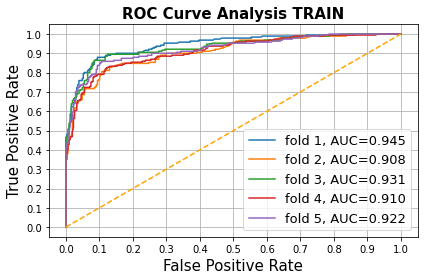

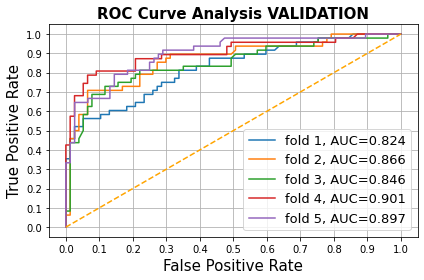

In [42]:
catb_model.get_rocauc_plots()

In [43]:
catb_model.get_curve_plots()

## 6. LGBMClassifier

In [44]:
params = {
    'learning_rate':0.01,
    'n_estimators':1000,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary',
    'n_jobs':-1,
    'random_state':42,
#    'eval_metric':'auc'
}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':25}

# создаем экземпляр класса LightGBM
lgb = LGBMClassifier(**params)

In [45]:
lgb_model = AutoTrees(
    main_estimator=lgb, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'lightboost')

In [46]:
lgb_model.model_fit_cv(strat=strat)

1it [00:00,  6.09it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.588642	training's auc: 0.91409	valid_1's binary_logloss: 0.610696	valid_1's auc: 0.802895
[50]	training's binary_logloss: 0.532684	training's auc: 0.920656	valid_1's binary_logloss: 0.575504	valid_1's auc: 0.797754
[75]	training's binary_logloss: 0.49109	training's auc: 0.925098	valid_1's binary_logloss: 0.551861	valid_1's auc: 0.797348
[100]	training's binary_logloss: 0.457261	training's auc: 0.926292	valid_1's binary_logloss: 0.532354	valid_1's auc: 0.796807
BEST ITERATION:  23
gini на обучающей выборке: 82.832
gini на проверочной выборке: 61.012

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00,  5.84it/s]

[25]	training's binary_logloss: 0.591783	training's auc: 0.902809	valid_1's binary_logloss: 0.608713	valid_1's auc: 0.834821
[50]	training's binary_logloss: 0.537394	training's auc: 0.911788	valid_1's binary_logloss: 0.57351	valid_1's auc: 0.842127
[75]	training's binary_logloss: 0.497967	training's auc: 0.915727	valid_1's binary_logloss: 0.547875	valid_1's auc: 0.83888
[100]	training's binary_logloss: 0.465347	training's auc: 0.918226	valid_1's binary_logloss: 0.527354	valid_1's auc: 0.837527
[125]	training's binary_logloss: 0.43893	training's auc: 0.92179	valid_1's binary_logloss: 0.51161	valid_1's auc: 0.836986
[150]	training's binary_logloss: 0.416476	training's auc: 0.923726	valid_1's binary_logloss: 0.498366	valid_1's auc: 0.835904
BEST ITERATION:  53
gini на обучающей выборке: 82.347
gini на проверочной выборке: 68.750

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss

3it [00:00,  5.04it/s]

[125]	training's binary_logloss: 0.437008	training's auc: 0.926582	valid_1's binary_logloss: 0.502793	valid_1's auc: 0.844156
[150]	training's binary_logloss: 0.413718	training's auc: 0.928927	valid_1's binary_logloss: 0.488873	valid_1's auc: 0.843344
[175]	training's binary_logloss: 0.397217	training's auc: 0.931511	valid_1's binary_logloss: 0.481675	valid_1's auc: 0.844697
[200]	training's binary_logloss: 0.382244	training's auc: 0.934751	valid_1's binary_logloss: 0.476942	valid_1's auc: 0.843344
[225]	training's binary_logloss: 0.368769	training's auc: 0.938025	valid_1's binary_logloss: 0.471928	valid_1's auc: 0.844697
[250]	training's binary_logloss: 0.359245	training's auc: 0.93968	valid_1's binary_logloss: 0.469308	valid_1's auc: 0.84118
[275]	training's binary_logloss: 0.3484	training's auc: 0.942187	valid_1's binary_logloss: 0.464462	valid_1's auc: 0.842262
BEST ITERATION:  192
gini на обучающей выборке: 86.660
gini на проверочной выборке: 69.426

********************** 3 фолд 

4it [00:00,  5.27it/s]

[75]	training's binary_logloss: 0.508287	training's auc: 0.907777	valid_1's binary_logloss: 0.507389	valid_1's auc: 0.898867
[100]	training's binary_logloss: 0.477417	training's auc: 0.910491	valid_1's binary_logloss: 0.475957	valid_1's auc: 0.90163
BEST ITERATION:  24
gini на обучающей выборке: 79.357
gini на проверочной выборке: 80.713

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.59341	training's auc: 0.89618	valid_1's binary_logloss: 0.600969	valid_1's auc: 0.886787
[50]	training's binary_logloss: 0.542555	training's auc: 0.902648	valid_1's binary_logloss: 0.549854	valid_1's auc: 0.897889
[75]	training's binary_logloss: 0.504149	training's auc: 0.907051	valid_1's binary_logloss: 0.51374	valid_1's auc: 0.897889
[100]	training's binary_logloss: 0.473525	training's auc: 0.909329	valid_1's binary_logloss: 0.485864	valid_1's auc: 0.898986
[125]	training's binary_loglos

5it [00:00,  5.21it/s]

[225]	training's binary_logloss: 0.383668	training's auc: 0.921891	valid_1's binary_logloss: 0.416324	valid_1's auc: 0.899808
[250]	training's binary_logloss: 0.374122	training's auc: 0.92371	valid_1's binary_logloss: 0.410047	valid_1's auc: 0.89926
BEST ITERATION:  170
gini на обучающей выборке: 83.372
gini на проверочной выборке: 80.126

********************** 5 фолд обучен! ******************************




In [47]:
lgb_model.get_mean_cv_scores()

72.00546245933984

In [48]:
lgb_model._best_iters

[23, 53, 192, 24, 170]

In [49]:
lgb_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.91                 0.91                 0.93   
1   roc_valid                 0.81                 0.84                 0.85   
2  gini_train                82.83                82.35                86.66   
3  gini_valid                61.01                68.75                69.43   

                fold_4               fold_5  
0                 0.90                 0.92  
1                 0.90                 0.90  
2                79.36                83.37  
3                80.71                80.13

In [50]:
fi = lgb_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex             2,305.14             3,484.92             6,755.70   
1      Fare               476.18             1,333.27             3,069.21   
2    Pclass               318.58               977.40             1,602.95   
3       Age               338.31               475.16             1,478.90   
4     Parch                52.33               179.31               461.83   
5  Embarked                99.88               132.94               385.56   
6     SibSp                47.59                95.98               191.89   

          importance 3         importance 4      mean_importance  
0             1,952.91             6,309.48             4,161.63  
1               483.13             2,266.15             1,525.59  
2               314.21             1,353.91               913.41  
3               275.34             1,688.86               851.31  
4                41.12               448.22               236.56  
5               106.62               297.73               204.54  
6               188.41               258.01               156.38

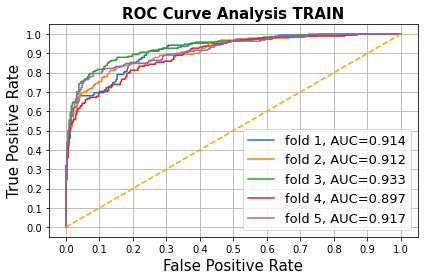

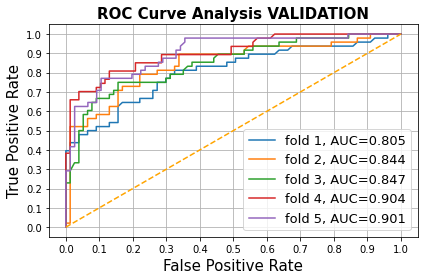

In [51]:
lgb_model.get_rocauc_plots()

In [52]:
lgb_model.get_curve_plots()